In [10]:
!mkdir -p ~/.kaggle

In [2]:
!kaggle datasets download -d salader/dogs-vs-cats

Dataset URL: https://www.kaggle.com/datasets/salader/dogs-vs-cats
License(s): unknown
100%|██████████████████████████████████████▊| 1.06G/1.06G [00:06<00:00, 178MB/s]
100%|███████████████████████████████████████| 1.06G/1.06G [00:06<00:00, 183MB/s]


In [3]:
import zipfile
zip_ref = zipfile.ZipFile('/kaggle/working/dogs-vs-cats.zip', 'r')
zip_ref.extractall('/kaggle/working')
zip_ref.close()

In [4]:
import tensorflow
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense,Flatten
from keras.applications.vgg19 import VGG19

In [5]:
conv_base = VGG19(
    weights='imagenet',
    include_top = False,
    input_shape=(224,224,3)
)

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


# Fine Tuning For Better Accuracy and less Overfitting

In [6]:
# Allow fine-tuning of the convolutional base starting from a specific layer
conv_base.trainable = True  # Enable training for the convolutional base

set_trainable = False  # Initialize a flag to mark layers as non-trainable

# Iterate through each layer in the convolutional base
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':  # Identify the starting layer for fine-tuning
        set_trainable = True          # Enable training for layers after this layer
    if set_trainable:
        layer.trainable = True        # Mark the layer as trainable
    else:
        layer.trainable = False       # Mark the layer as non-trainable

# Print the trainable status of each layer for verification
for layer in conv_base.layers:
    print(layer.name, layer.trainable)


input_layer False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_conv4 False
block3_pool False
block4_conv1 False
block4_conv2 False
block4_conv3 False
block4_conv4 False
block4_pool False
block5_conv1 True
block5_conv2 True
block5_conv3 True
block5_conv4 True
block5_pool True


### **Purpose and Significance**:
- **Purpose**: Adjusts the trainable status of layers in the convolutional base to fine-tune specific layers while keeping others frozen.
- **Significance**:
  - **Fine-Tuning**: Allows updating weights of deeper layers (from `block5_conv1` onward) to adapt the pre-trained model to the new task while preserving general features from earlier layers.
  - **Controlled Training**: Freezing earlier layers prevents overfitting and speeds up training by retaining learned features from the ImageNet dataset.

In [7]:
conv_base.summary()

Model: "vgg19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv4 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv4 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv4 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 20,024,384 (76.39 MB)

 Trainable params: 9,439,232 (36.01 MB)

 Non-trainable params: 10,585,152 (40.38 MB)

In [8]:
# Building the sequential model

model = Sequential()  # Initialize a sequential model

# Adding the pre-trained convolutional base
model.add(conv_base)
# conv_base: Pre-trained VGG19 model (without the top layers) used as the feature extractor.

# Adding a flattening layer to convert 2D features into a 1D array
model.add(Flatten())
# Flatten: Converts the multi-dimensional output of the convolutional base into a single vector.

# Adding a fully connected dense layer with 256 neurons and ReLU activation
model.add(Dense(256, activation='relu'))
# Dense(256): Fully connected layer with 256 neurons to learn complex patterns.
# activation='relu': Introduces non-linearity to the layer's output.

# Adding the output layer with 1 neuron and sigmoid activation
model.add(Dense(1, activation='sigmoid'))
# Dense(1): Final layer with 1 neuron for binary classification.
# activation='sigmoid': Outputs probabilities for two classes (0 or 1).



### **Purpose and Significance**:
- **Purpose**: Combines the pre-trained VGG19 base with new dense layers to form a complete model for binary classification.
- **Significance**:
  - **Feature Extraction**: The pre-trained VGG19 base extracts high-quality features from input images.
  - **Classification Layers**: The added dense layers learn to classify these features into two categories (binary classification).
  - **Modularity**: Sequential API allows stacking layers in a straightforward and readable way.

In [9]:
# Generators for loading and preprocessing data

# Creating a dataset for training
train_ds = keras.utils.image_dataset_from_directory(
    directory='/kaggle/working/train',  # Directory containing the training data
    labels='inferred',          # Automatically infer labels from the folder structure
    label_mode='int',           # Labels are integers (e.g., 0 or 1 for binary classification)
    batch_size=32,              # Number of images in each batch
    image_size=(224, 224)       # Resize all images to 224x224 (matching the input shape of the model)
)

# Creating a dataset for validation
validation_ds = keras.utils.image_dataset_from_directory(
    directory='/kaggle/working/test',  # Directory containing the validation data
    labels='inferred',          # Automatically infer labels from the folder structure
    label_mode='int',           # Labels are integers
    batch_size=32,              # Number of images in each batch
    image_size=(224, 224)       # Resize all images to 224x224
)


Found 20000 files belonging to 2 classes.
Found 5000 files belonging to 2 classes.



### **Purpose and Significance**:
- **Purpose**:
  - Load image datasets from directories while resizing and batching them for training and validation.
- **Significance**:
  - **Automated Labeling**: Automatically assigns labels based on folder structure.
  - **Standardization**: Ensures images are of uniform size and shape for input into the model.
  - **Batching**: Enables efficient processing by dividing the dataset into smaller, manageable groups.

In [10]:
# Normalizing the dataset

# Function to normalize the image data
def process(image, label):
    image = tensorflow.cast(image / 255.0, tensorflow.float32)  # Scale pixel values to the range [0, 1]
    return image, label

# Apply normalization to the training dataset
train_ds = train_ds.map(process)
# Apply normalization to the validation dataset
validation_ds = validation_ds.map(process)


In [11]:
# Compiling the model

model.compile(
    optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),  # Optimizer with a low learning rate , works well in Fine Tuning
    loss='binary_crossentropy',  # Loss function for binary classification
    metrics=['accuracy']  # Metric to evaluate the model's performance
)


In [13]:
history = model.fit(train_ds,epochs=5,validation_data=validation_ds)

Epoch 1/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 185s 269ms/step - accuracy: 0.8632 - loss: 0.2926 - val_accuracy: 0.9540 - val_loss: 0.1123
Epoch 2/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 167s 268ms/step - accuracy: 0.9620 - loss: 0.1005 - val_accuracy: 0.9640 - val_loss: 0.0887
Epoch 3/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 168s 268ms/step - accuracy: 0.9792 - loss: 0.0590 - val_accuracy: 0.9654 - val_loss: 0.0823
Epoch 4/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 168s 268ms/step - accuracy: 0.9893 - loss: 0.0352 - val_accuracy: 0.9440 - val_loss: 0.1535
Epoch 5/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 168s 268ms/step - accuracy: 0.9943 - loss: 0.0197 - val_accuracy: 0.9584 - val_loss: 0.1173


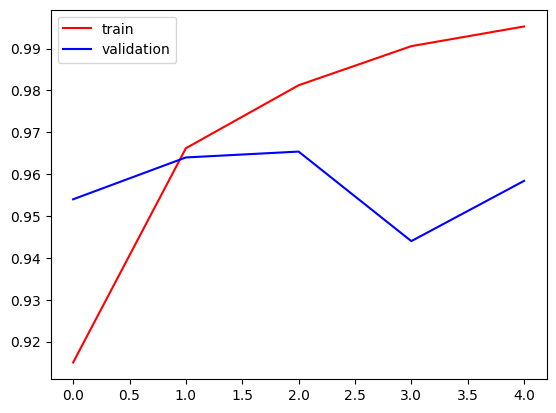

In [14]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'],color='red',label='train')
plt.plot(history.history['val_accuracy'],color='blue',label='validation')
plt.legend()
plt.show()

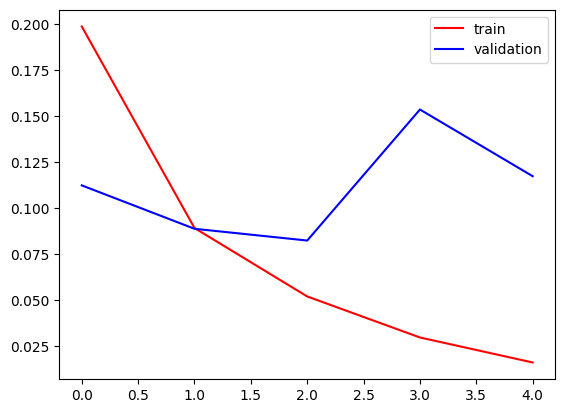

In [15]:
plt.plot(history.history['loss'],color='red',label='train')
plt.plot(history.history['val_loss'],color='blue',label='validation')
plt.legend()
plt.show()